# Information Diffusion for Vote Selection

This notebook explores techniques from heat diffusion (e.g. used to model information diffusion in social networks in compute science) to compute areas of maximum uncertainty in the document graph.

This algorithm is used to select which unvoted (document) nodes to request votes for. It is quite effective at selecting the most useful documents thereby increasing the accuracy of the system with even a very low budget.

Greedy algorithm for submodular function maximization, i.e. coverage, over the independent cascades (IC) model:

 * For budget = 1 to n_documents
   * Simulate process k times for every new candidate, and pick candidate which, on average (i.e. in expectation), when added to the seed set maximizes the spread caused by the seed set

Request these votes, and aggregate in a fixed way (e.g. MV or MVNN).

TODO(andrei): Integrate this code into the Gaussian Processes framework for sensible comparison with other research in the field. 

In [1]:
%load_ext autoreload

In [2]:
import os
import sys

# If you're using Anaconda and this doesn't correspond to the correct environment
# (i.e. the one active when 'jupyter notebook' was called), run
#     $ ipython3 kernel install 
# and restart the notebook.
print("Current Python: {0}".format(sys.executable))

# This makes Jupyter pretend to be Pythonic and play well with modules.
sys.path.append(os.path.expandvars(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from collections import OrderedDict
from datetime import datetime
import io
import os
import random

%matplotlib inline

Current Python: /Users/andrei/anaconda3/envs/crowd/bin/python


In [15]:
%autoreload 2

from crowd.aggregation import *
from crowd.config import *
from crowd.data import *
from crowd.file_util import *
from crowd.graph import *
from crowd.graph_sampling import *
from crowd.simulation import *
from crowd.topic import *
from crowd.util import *

In [16]:
# Make sure we operate in the same directory as the other tools
# in the project.
if 'notebooks' in os.getcwd():
    print(os.getcwd())
    os.chdir('..')
    print(os.getcwd())

In [17]:
SIM_THRESHOLD = 0.75
DISCARD_EMPTY_NODES = True

id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

# Pick one single topic to mess around with at the moment.
# Topic: 20814 Elvish Language
topic_id = '20814'
# topic_id = '20704'
graph = build_nx_document_graph(
    id_topic_info[topic_id],
    test_data,
    get_topic_judgements_by_doc_id(topic_id, judgements),
    FULLTEXT_FOLDER,
    sim_threshold=SIM_THRESHOLD,
    discard_empty=DISCARD_EMPTY_NODES)
classic_graph = build_document_graph(
    id_topic_info[topic_id],
    FULLTEXT_FOLDER,
    sim_threshold=SIM_THRESHOLD)
topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}
print(len(topic_judgements.keys()))
print(len(topic_ground_truth.keys()))

# Important note: Not discarding empty nodes significantly slows the algorithm
# down, since the information propagation must then be computed on a much larger
# graph.
if DISCARD_EMPTY_NODES:
    print("Will DISCARD empty nodes in the graph.")
else:        
    # TODO(andrei): Ensure that when we're sampling, we DON'T try to sample
    # any of the votes which have not recorded votes.
    print("Not discarding empty nodes")
    
print("Nodes: {}".format(graph.nx_graph.number_of_nodes()))
print("Edges: {}".format(graph.nx_graph.number_of_edges()))

Building nx doc graph
7 relevant documents
3 non-relevant documents
100 documents with votes
66 hidden nodes (due to no data)
100
100
Will DISCARD empty nodes in the graph.
Nodes: 100
Edges: 62


In [18]:
# This is just a sanity check preview. It's not nearly
# as useful as the one in the dedicated similarity graph
# visualization notebook.
# TODO(andrei): Consider always working with NetworkX graphs directly, if it makes sense.

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph.nx_graph)
# nx.draw(graph.nx_graph, pos, node_size=2500, node_color='w')
# _ = nx.draw_networkx_labels(graph.nx_graph, pos)
# # _ = nx.draw_networkx_edge_labels(graph.nx_graph, pos)
# nx.draw_networkx_edges(graph.nx_graph, pos)

print("Connected components: {}".format(nx.number_connected_components(graph.nx_graph)))
print("Cliques:              {}".format(nx.graph_number_of_cliques(graph.nx_graph)))

# nx.draw(graph.nx_graph)

Connected components: 68
Cliques:              70


In [19]:
ng = graph.nx_graph
n_docs = ng.number_of_nodes()

In [20]:
# Getting a particular node's neighbors.
# Note that the actual node objects are of type 'NxDocumentNode'.
ng['clueweb09-en0007-20-27316']

{clueweb09-en0020-09-05220: {'similarity': 0.83260761009306117},
 clueweb09-en0022-00-14843: {'similarity': 0.82834612080853465},
 clueweb09-en0027-48-27832: {'similarity': 0.95115279699710087},
 clueweb09-en0035-25-25842: {'similarity': 0.83333782655166722},
 clueweb09-en0065-64-28203: {'similarity': 0.78686207716967493},
 clueweb09-en0112-39-04197: {'similarity': 0.9701917457905459}}

## TODO list
 * Problem: What to do once we reach 100% coverage, i.e. 1 vote for every document?
     * We encounter a similar problem to GP aggregation, cyclicity. Namely, influence spread is maximized when we have sampled every node exactly once, but this doesn't mean that we should be 100% confident our predictions are correct.
     * We need a smart way to model uncertainty beyond 1 vote per doc.
     * Possible solution: Remodel influence maximization problem so that every node spreads information based on its own confidence. If there is consent among voters so far, then its weight is higher than if there is dissent.
 * Write script for one-command deployment to Euler (hint: use pyinvoke).
 * Model IC/LT configs in a neat OO fashion.
 * Consider estimating the number of tries necessary if using a brute-force approach. For instance, for $n = 150$ documents and a budget $k = b = 15$ we would have to check about $10^{20}$ possible subsets. And this doesn't even count possible uncertainties and needing >1 vote per document to be confident in its relevance. We need submodularity! The **k-max cover problem** is NP-hard.
 
 
### Done
 * Simulate one iteration of influence maximization under IC.
 * Create function which repeats simulation k several times, and computes the expected influence of a given seed set.
 * Create function which, given a seed set, finds the best addition to that seed set using the above function.
 * Create function which, given a graph and a budget b, computes the approximately best solution to maximize influence.
     * These will be the votes we will request.
 * Plot learning curves for this system, e.g. from budget = 1, up to budget = n_docs, or even n_docs * nr_votes_per doc.
 * This technique is VERY CPU-intensive, but also embarrassingly parallel, so we should parallelize it.

In [21]:
import random

## Lazy Greedy

In [22]:
# General benchmarks; topic = 20814
#
#  * Very first timing,               b = 10, it = 10:    77639828 function calls in 26.211 seconds
#  * Pre-cached node hash,            b = 10, it = 10:    49998191 function calls in 20.735, 21.717, 21.289 seconds
#  * First buggy lazy greedy attempt, b = 10, it = 10:    25624964 function calls in 10.595 seconds
#  * Second less buggy lg attempt,    b = 30, it = 10:    139919933 function calls in 57.896 seconds 
#    spread = 61.60
# Fishy...
#  * Non-lg                           b = 30, it = 10:    138283442 function calls in 57.391 seconds
#    spread = 61.20


# Clique-based investigation:
#  lt  lazy greedy comparison:  {'miss': 12, 'hit': 5}, spread == 49.5
#  lte lazy greedy comparison:  {'miss': 12, 'hit': 5} spread == 49.5
#  epsilon 0.1 lazy greedy comparison: {'miss': 13, 'hit': 4}  Spread == 49.50
#  epsilon 0.5 lazy greedy comparison: {'miss': 8, 'hit': 9}   Spread == 49.20
#  epsilon 1.0 lazy greedy comparison: {'miss': 8, 'hit': 9}   Spread == 49.20
#  epsilon 2.5 lazy greedy comparison: {'miss': 5, 'hit': 12}  Spread == 49.20

plt.rcParams['figure.figsize'] = (18, 10)

random.seed(0xFFF000)
#%prun
result = build_seed_set_lg(graph.nx_graph, 15, 10)
clean_res = []
for r in result:
    d_id = r.document_id
    d_id = d_id[d_id.find('-') + 1:]
    d_id = d_id[d_id.find('-') + 1:]
    clean_res.append(d_id)
    
print(sorted(clean_res))

Budget: 1/15, Spread: -8.00
Budget: 2/15, Spread: -14.00
Budget: 3/15, Spread: -18.00
Budget: 4/15, Spread: -22.00
Budget: 5/15, Spread: -25.00
Budget: 6/15, Spread: -27.00
Budget: 7/15, Spread: -26.90
Budget: 8/15, Spread: -30.90
Budget: 9/15, Spread: -32.80
Budget: 10/15, Spread: -35.00
Budget: 11/15, Spread: -37.00
Budget: 12/15, Spread: -36.80
Budget: 13/15, Spread: -38.60
Budget: 14/15, Spread: -40.40
Budget: 15/15, Spread: -42.70
Stats:  {'hit': 7, 'miss': 7}
 ['03-20850', '03-20962', '08-09915', '09-05220', '14-28985', '15-00571', '18-32052', '22-17024', '23-17067', '33-00282', '34-30758', '38-43081', '48-02434', '57-36727', '64-25797']


In [23]:
if False:
    # Note: this function is likely incorrect.
    result = build_seed_set(graph.nx_graph, 10, 10)
    clean_res = []
    for r in result:
        d_id = r.document_id
        d_id = d_id[d_id.find('-') + 1:]
        d_id = d_id[d_id.find('-') + 1:]
        clean_res.append(d_id)

    print(sorted(clean_res))

## Sampling + vote aggregation

In [24]:
# Least votes sampling
print("Oldschool least-votes")
accuracies_mv_lowvotes = evaluate_iteration(
    classic_graph,
    topic_judgements,
    topic_ground_truth,
    LeastVotesSampler(),
    aggregate_MV,
    budget=len(topic_ground_truth.keys()))
accuracies_mev_lowvotes = evaluate_iteration(
    classic_graph,
    topic_judgements,
    topic_ground_truth,
    LeastVotesSampler(),
    aggregate_mev,
    budget=len(topic_ground_truth.keys()))
    
# IC sampling
print("IC")
accuracies_mev = evaluate_iteration(
    graph,
    topic_judgements,
    topic_ground_truth,
#     GraphSpreadSampler(graph, iteration_count=5),
    LazyGreedyGraphSpreadSampler(graph, iteration_count=5),
    aggregate_mev_nx,
    budget=len(topic_ground_truth.keys()))
accuracies_mv = evaluate_iteration(
    graph,
    topic_judgements,
    topic_ground_truth,
#     GraphSpreadSampler(graph, iteration_count=5),
    LazyGreedyGraphSpreadSampler(graph, iteration_count=5),
    aggregate_MV,
    budget=len(topic_ground_truth.keys()))
print("Done.")

Oldschool least-votes
IC
Done.


In [1]:
# plt.plot(range(len(accuracies_mev_lowvotes)), accuracies_mev_lowvotes, label="MEV classic", marker='x')
# #plt.plot(range(len(accuracies_mv_lowvotes)), accuracies_mv_lowvotes, label="MV", marker='x')

# plt.plot(range(len(accuracies_mev)), accuracies_mev, label="MEV information", marker='^')
# #plt.plot(range(len(accuracies_mv)), accuracies_mv, label="MV", marker='^')
# plt.legend(loc='lower right')

Comparing least-votes and graph-based sampling for topic: detroit riot (ID#20704)
Building nx doc graph
5 relevant documents
5 non-relevant documents
90 documents with votes
51 hidden nodes (due to no data)
Judgements: 90
Ground truths: 90
Computing results for IC Information Spread Sampler...
Computing results for LeastVotesSampler...
Plotting...


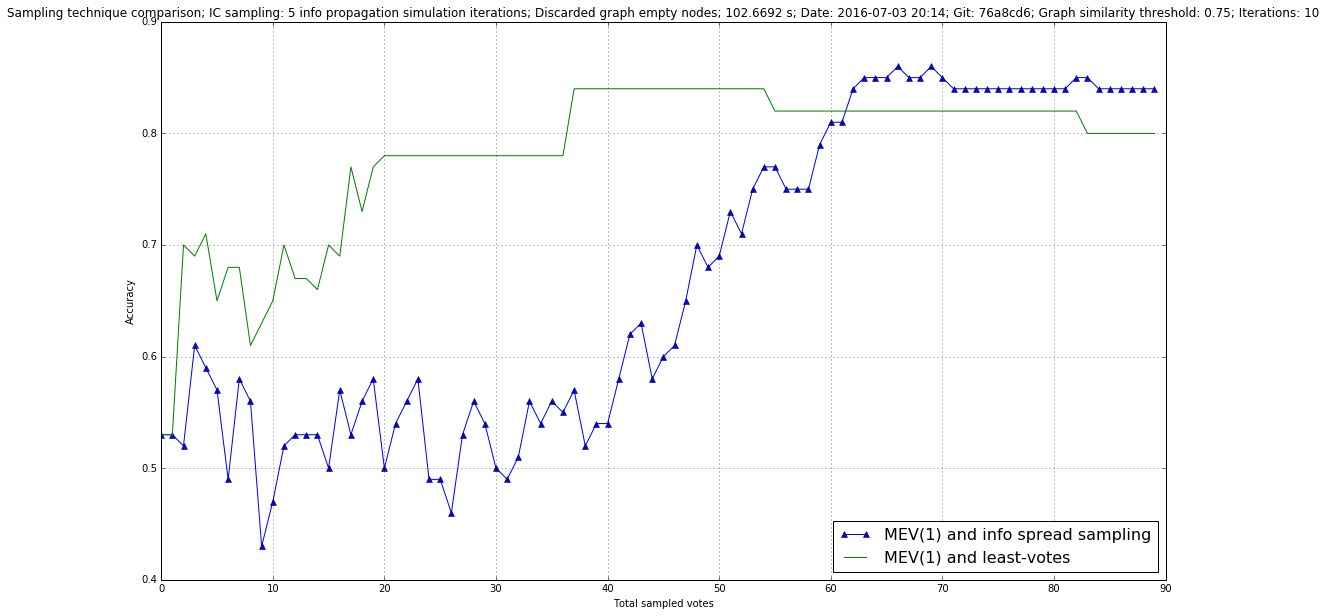

In [26]:
# Experimentation with the code from 'graph_sampling.py'
compare_sampling('20704',
                 sim_threshold=SIM_THRESHOLD,
                 discard_empty_nodes=DISCARD_EMPTY_NODES)

## Thoughts on also achieving voting confidence

 * Need **measure** of confidence in node.
 * Need to adapt sampling. With IC model, as soon as we reach a node with one edge, we "activate" it.
 * Linear Threshold (LT) model could be better? Then, a node would only "activate" if k neighbors (depending on similarity and its internal threshold) give it a heads-up. Still doesn't model confidence in votes in a particular node.
 * What if we re-weight the edges based the number of nodes? Still can't make the model want to pick a node more than once.
 * What about always picking e.g. 4 votes? If there's consent, we don't look at the node ever again until it's picked "naturally" again. If not, we want more votes there. Maybe just pick e.g. 4 votes again. If still no consent give up?
 
Want to do global sampling based on confidence and informativeness. I.e. we want to weight informativeness by lack of confidence, in order to prioritize nodes where we have little confidence in their relevance.

Compute top most informative (next) node as in the original plan by the new seed set spread, but then modulate every node's score by the confidence in that prediction. WON'T WORK because all candidates have never been sampled before by
definition.

How to extend information diffusion to allow multiple sampling of same node to further increase information flow?

What does it mean to not have confidence in a document's relevance?
 * It has very few votes or none at all.
 * There's dissent among voters.
 * Want to design a `function(node, pos_votes, neg_votes)` which represents a measure of our confidence in its relevance.
 * We then want to use this somehow in conjunction with another sampling technique to pick the best node at a given time.
     * How?


## (Old) Result Log

First algorithm testing. SIM_THRESHOLD = 0.75, topic = '20814'

* B = 10, it = 1

```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 25.00
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 33.00
Budget: 10/10, Spread: 35.00
['11-30471', '15-00571', '22-17024', '23-17065', '34-30758', '61-26427', '62-23911', '67-08444', '87-16214', '89-19116']
```

* B = 10, it = 5
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 25.00
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 33.00
Budget: 10/10, Spread: 35.00
['03-20962', '15-00571', '18-32052', '22-17024', '23-17065', '57-36745', '61-26427', '67-08444', '87-16214', '89-19116']
```
 
 * B = 10, it = 10:
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 14.00
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 22.00
Budget: 5/10, Spread: 24.80
Budget: 6/10, Spread: 27.00
Budget: 7/10, Spread: 29.00
Budget: 8/10, Spread: 31.00
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 35.00
['08-09915', '09-38244', '22-17024', '23-17067', '34-30758', '61-26427', '67-08444', '78-09824', '87-16214', '91-14026']

```

 * B = 10, it = 50
 
```
Budget: 1/10, Spread: 8.00
Budget: 2/10, Spread: 13.98
Budget: 3/10, Spread: 18.00
Budget: 4/10, Spread: 21.98
Budget: 5/10, Spread: 24.92
Budget: 6/10, Spread: 26.90
Budget: 7/10, Spread: 28.84
Budget: 8/10, Spread: 30.94
Budget: 9/10, Spread: 32.90
Budget: 10/10, Spread: 34.80
['11-30471', '25-25842', '34-30758', '61-21414', '63-26631', '74-02002', '78-09824', '80-16439', '89-19116', '89-33025']
```

 * B = 10, it = 150
```
Budget: 1/10, Spread: 7.97
Budget: 2/10, Spread: 13.98
Budget: 3/10, Spread: 17.96
Budget: 4/10, Spread: 21.97
Budget: 5/10, Spread: 24.90
Budget: 6/10, Spread: 26.86
Budget: 7/10, Spread: 28.89
Budget: 8/10, Spread: 30.89
Budget: 9/10, Spread: 32.83
Budget: 10/10, Spread: 34.85
['09-38244', '18-32052', '22-17024', '34-30758', '48-27832', '61-26427', '64-25797', '74-02002', '87-16214', '89-19116']
```